In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'USD'
share_name = 'DNO.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2000-03-31,17,-2,16,6,9,0,0,32,13,...,144,0,0,4,28,13,69,1,0,50.2
1,2000-06-30,18,-2,16,2,6,0,0,20,12,...,143,0,0,0,24,13,64,10,0,50.2
2,2000-09-30,18,-3,15,-1,24,0,0,42,11,...,171,0,0,19,55,0,82,9,0,50.2
3,2000-12-31,22,-4,18,-1,10,0,0,39,15,...,182,0,0,12,37,17,91,-4,0,50.2
4,2001-03-31,32,-7,26,4,6,0,0,34,14,...,211,0,0,11,57,26,119,24,0,51.6


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
91,2022-12-31,2023-02-11,986.97,338,-146,193,43,932,312,47,...,97,2803,72,0,15,445,546,1434,245,-76
92,2023-03-31,2023-04-21,975.00,269,-105,164,87,887,416,54,...,109,2738,52,0,39,400,521,1373,107,-57
93,2023-06-30,2023-07-21,975.00,58,-57,2,-19,729,422,67,...,124,2640,90,0,170,444,390,1324,-68,-45
94,2023-09-30,2023-10-21,975.00,141,-88,54,-55,708,152,74,...,160,2583,91,0,170,415,391,1338,53,-26
95,2023-12-31,2024-02-11,975.00,199,-116,84,4,719,265,78,...,202,2638,0,0,166,415,392,1404,102,-36


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

NOK=X: Data doesn't exist for startDate = 946684800, endDate = 954457200
/Users/zsolt.nagy/Desktop/projects/Economy/notebooks/utils.ipynb:68: RuntimeWarning: Mean of empty slice.
  "    return filtered"
/Users/zsolt.nagy/Desktop/projects/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
NOK=X: Data doesn't exist for startDate = 954543600, endDate = 962319600
/Users/zsolt.nagy/Desktop/projects/Economy/notebooks/utils.ipynb:68: RuntimeWarning: Mean of empty slice.
  "    return filtered"
/Users/zsolt.nagy/Desktop/projects/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
NOK=X: Data doesn't exist for startDate = 962492400, endDate = 970268400
/Users/zsolt.nagy/Desktop/projects/Economy/notebooks/utils.ipynb:68: RuntimeWarning: Mean of empty slice.
  "    return filtered"
/Us

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
91,2022-12-31,2023-02-11,986.97,338,-146,193,43,932,312,47,...,2803,72,0,15,445,546,1434,245,-76,10.186402
92,2023-03-31,2023-04-21,975.00,269,-105,164,87,887,416,54,...,2738,52,0,39,400,521,1373,107,-57,10.221379
93,2023-06-30,2023-07-21,975.00,58,-57,2,-19,729,422,67,...,2640,90,0,170,444,390,1324,-68,-45,10.699984
94,2023-09-30,2023-10-21,975.00,141,-88,54,-55,708,152,74,...,2583,91,0,170,415,391,1338,53,-26,10.483742
95,2023-12-31,2024-02-11,975.00,199,-116,84,4,719,265,78,...,2638,0,0,166,415,392,1404,102,-36,10.821103


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
91,2022-12-31,2023-02-11,986.97,3443.003771,-1487.214647,1965.975526,438.015273,9493.726375,3178.157327,478.760879,...,28552.483937,733.420922,0.0,152.796025,4532.948752,5561.775323,14607.300023,2495.668414,-774.166528,10.186402
92,2023-03-31,2023-04-21,975.00,2749.550846,-1073.244754,1676.306092,889.259939,9066.362827,4252.093502,551.954445,...,27986.134633,531.511688,0.0,398.633766,4088.551444,5325.338256,14033.952831,1093.687511,-582.618581,10.221379
93,2023-06-30,2023-07-21,975.00,620.599055,-609.899071,21.399967,-203.299690,7800.288118,4515.393122,716.898908,...,28247.956971,962.998533,0.0,1818.997229,4750.792763,4172.993643,14166.778420,-727.598892,-481.499267,10.699984
94,2023-09-30,2023-10-21,975.00,1478.207628,-922.569299,566.122070,-576.605812,7422.489364,1593.528790,775.796911,...,27079.505687,954.020526,0.0,1782.236147,4350.752946,4099.143137,14027.246848,555.638328,-272.577293,10.483742
95,2023-12-31,2024-02-11,975.00,2153.399487,-1255.247942,908.972648,43.284412,7780.373021,2867.592282,844.046030,...,28546.069580,0.000000,0.0,1796.303090,4490.757724,4241.872356,15192.828541,1103.752501,-389.559706,10.821103


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2001-10-22,0.428342,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,0.39313,0.60687,inf,inf,5.76,inf,0.833333,0.138889,0.076336,0.194175
1,2001-10-29,0.459410,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,0.39313,0.60687,inf,inf,5.76,inf,0.833333,0.138889,0.076336,0.194175
2,2001-11-05,0.510640,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,0.39313,0.60687,inf,inf,5.76,inf,0.833333,0.138889,0.076336,0.194175
3,2001-11-12,0.469656,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,0.39313,0.60687,inf,inf,5.76,inf,0.833333,0.138889,0.076336,0.194175
4,2001-11-19,0.483207,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,0.39313,0.60687,inf,inf,5.76,inf,0.833333,0.138889,0.076336,0.194175


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2001-10-22,0.428342,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,inf,0.833333,0.138889,0.076336,0.194175,0.123844,0.024047,0.017201,0.947756,0.032590
1,2001-10-29,0.459410,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,inf,0.833333,0.138889,0.076336,0.194175,0.132826,0.025792,0.018448,0.949004,0.034954
2,2001-11-05,0.510640,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,inf,0.833333,0.138889,0.076336,0.194175,0.147638,0.028668,0.020505,0.951061,0.038852
3,2001-11-12,0.469656,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,inf,0.833333,0.138889,0.076336,0.194175,0.135789,0.026367,0.018860,0.949415,0.035734
4,2001-11-19,0.483207,2001-09-30,321.246655,3.458728,17.812449,51.6,678.187383,13.143166,223.087955,...,inf,0.833333,0.138889,0.076336,0.194175,0.139707,0.027127,0.019404,0.949959,0.036765


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

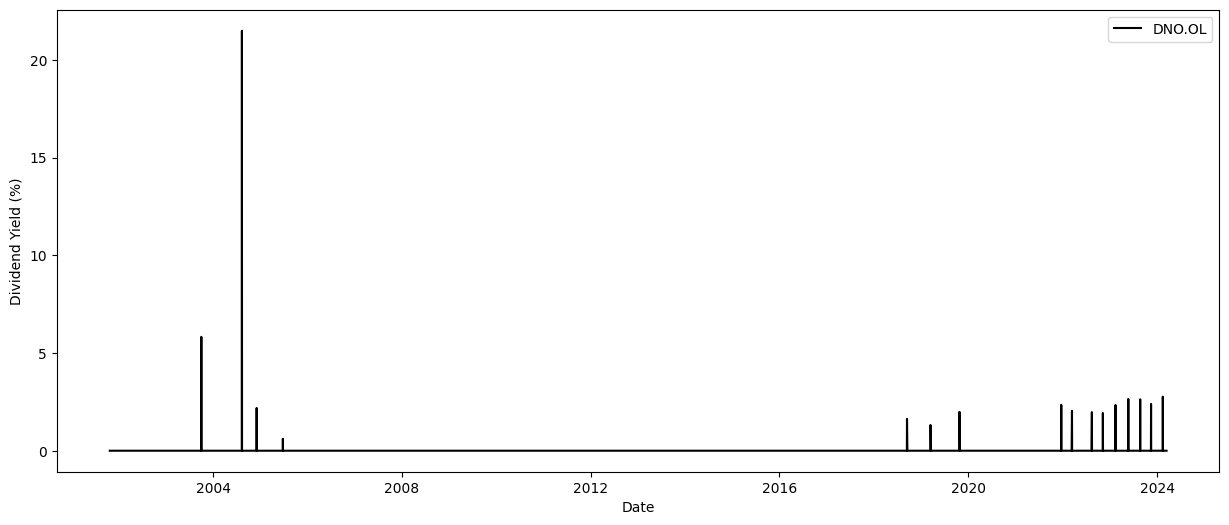

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.100459
share_price      1.000000
Name: share_price, dtype: float64


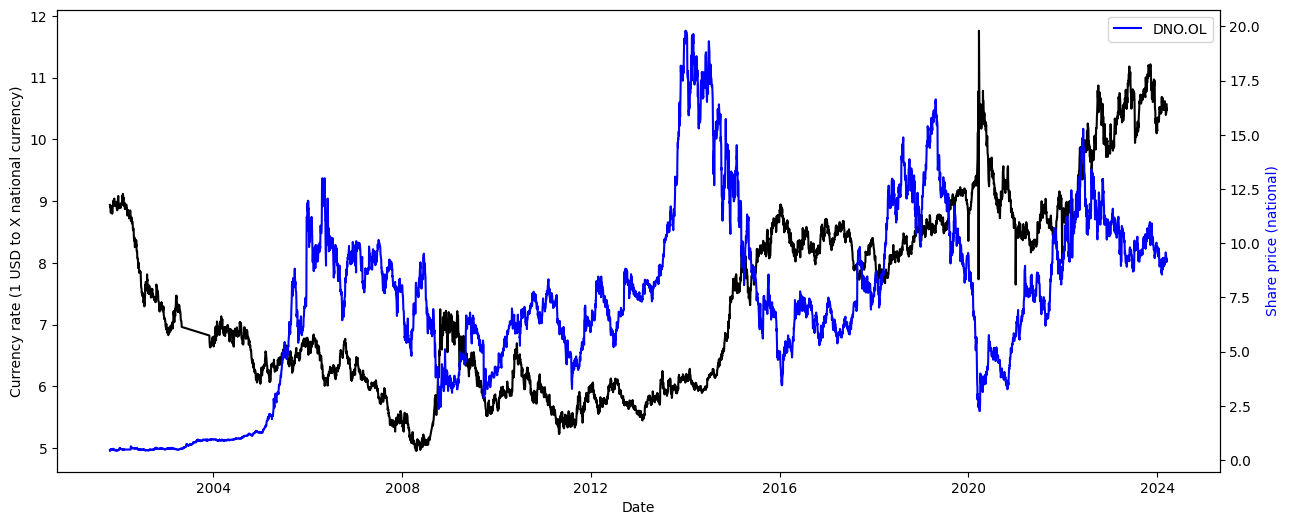

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

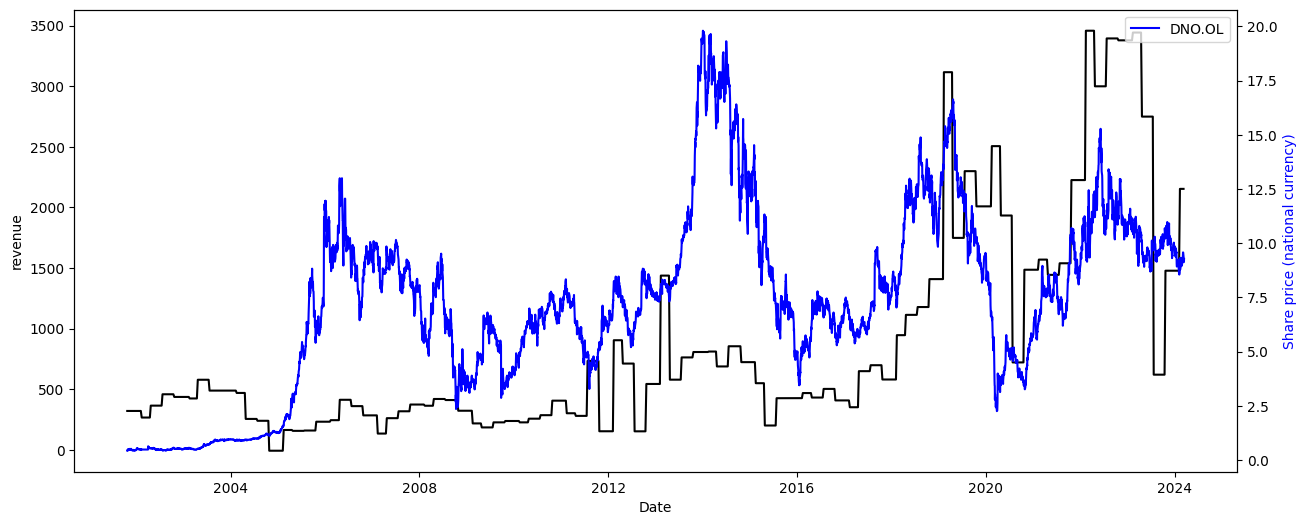

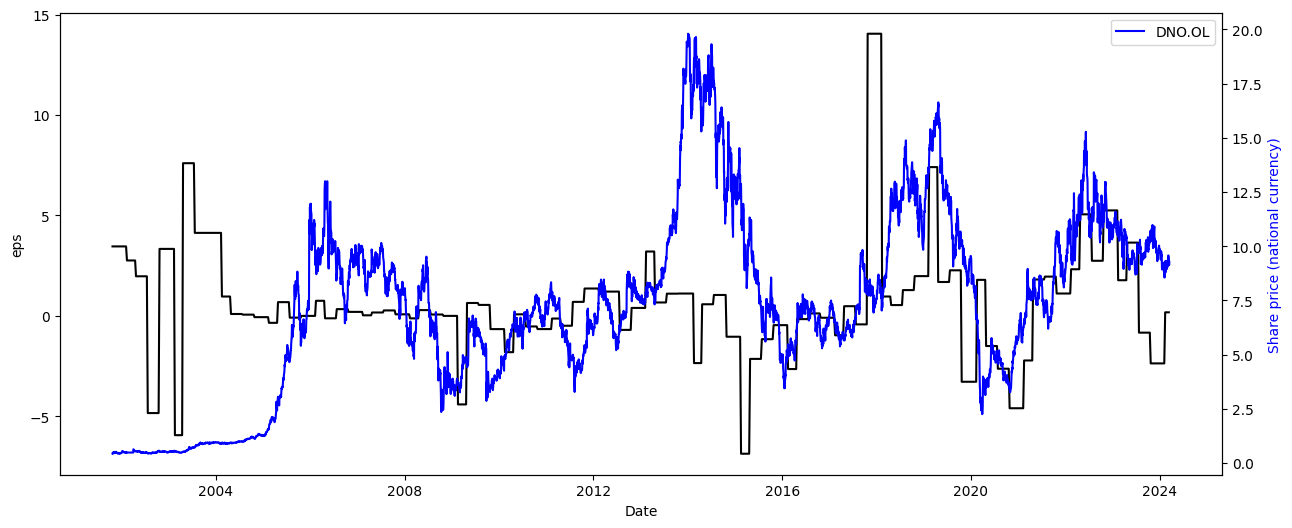

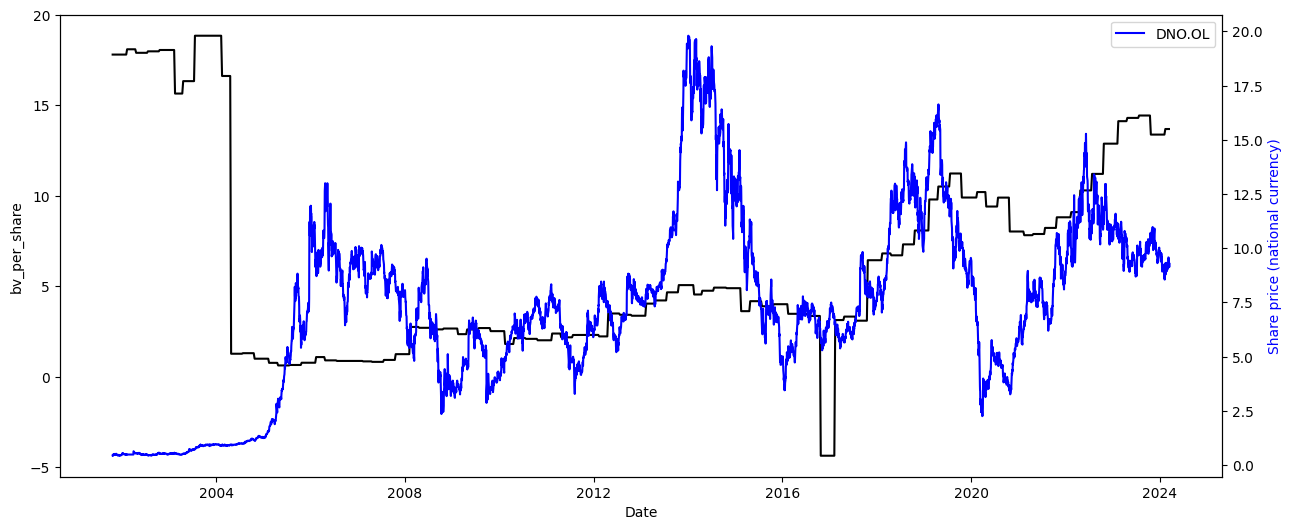

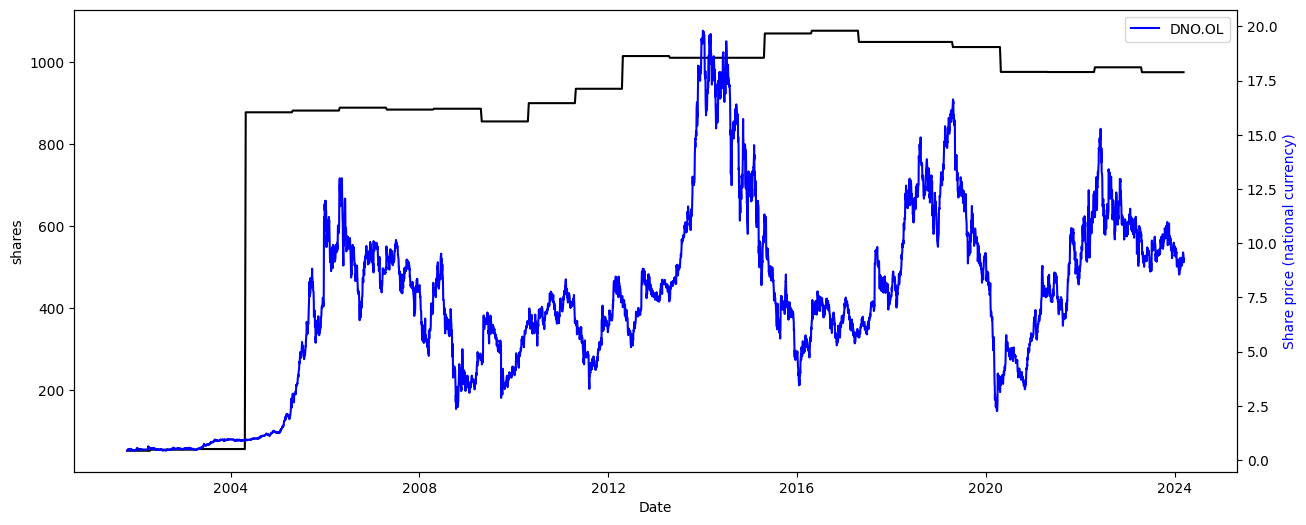

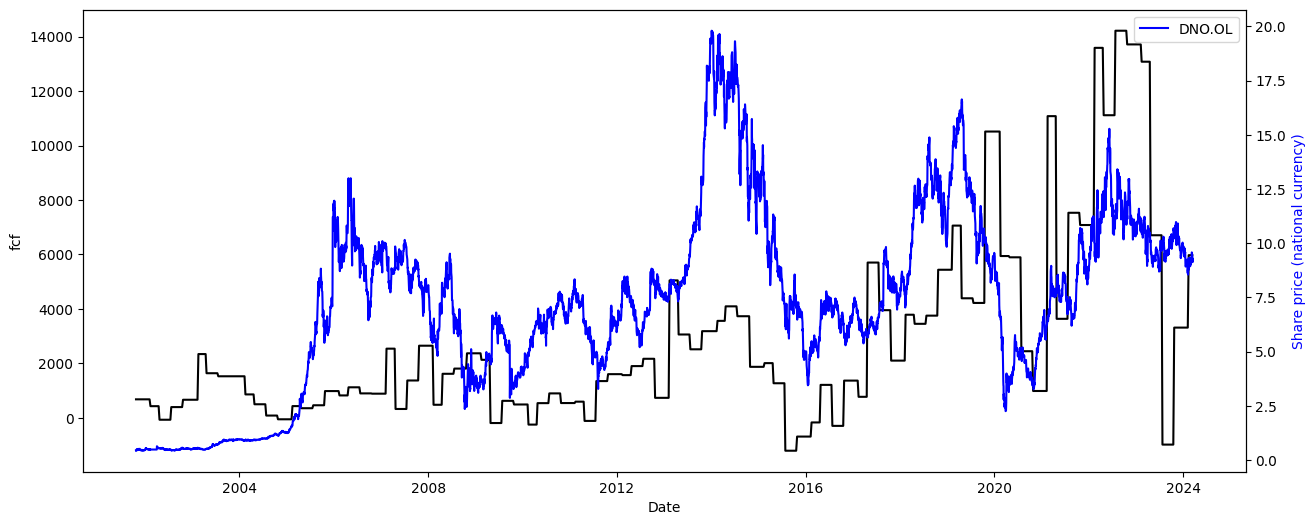

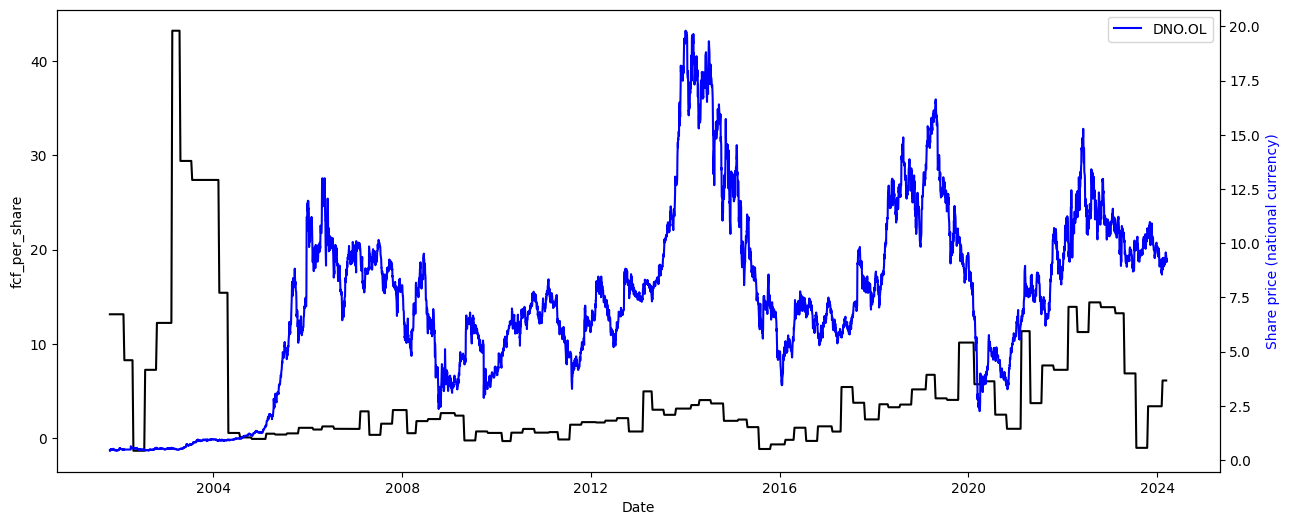

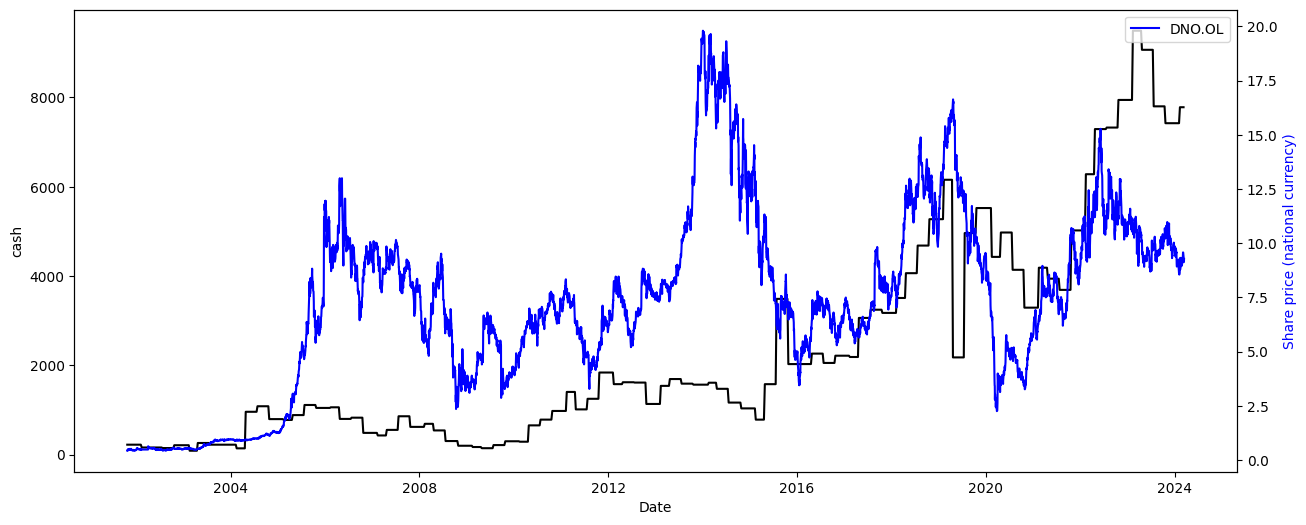

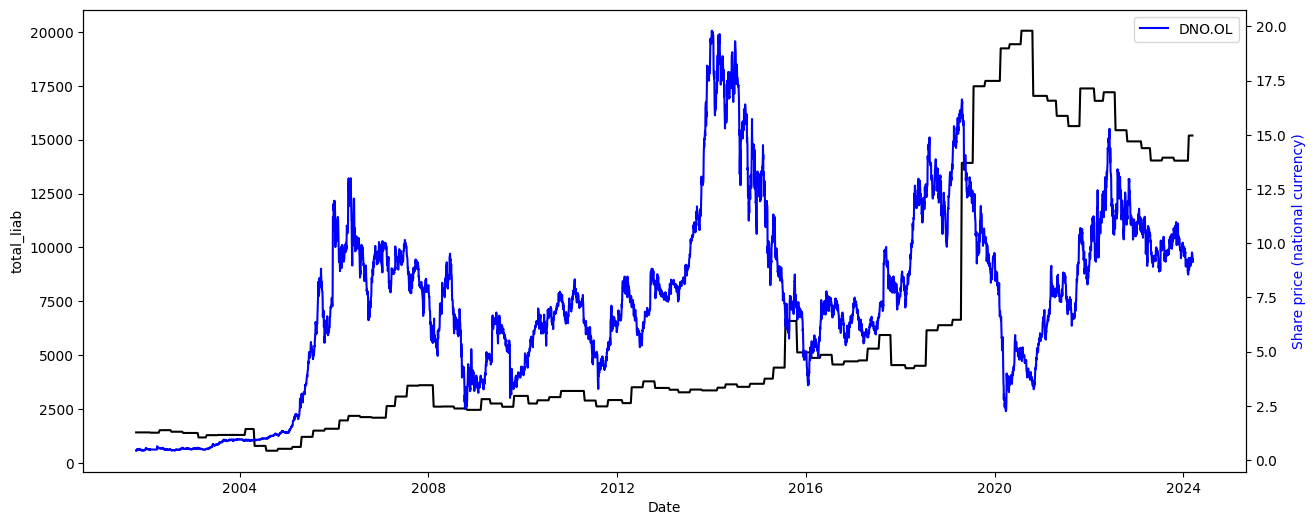

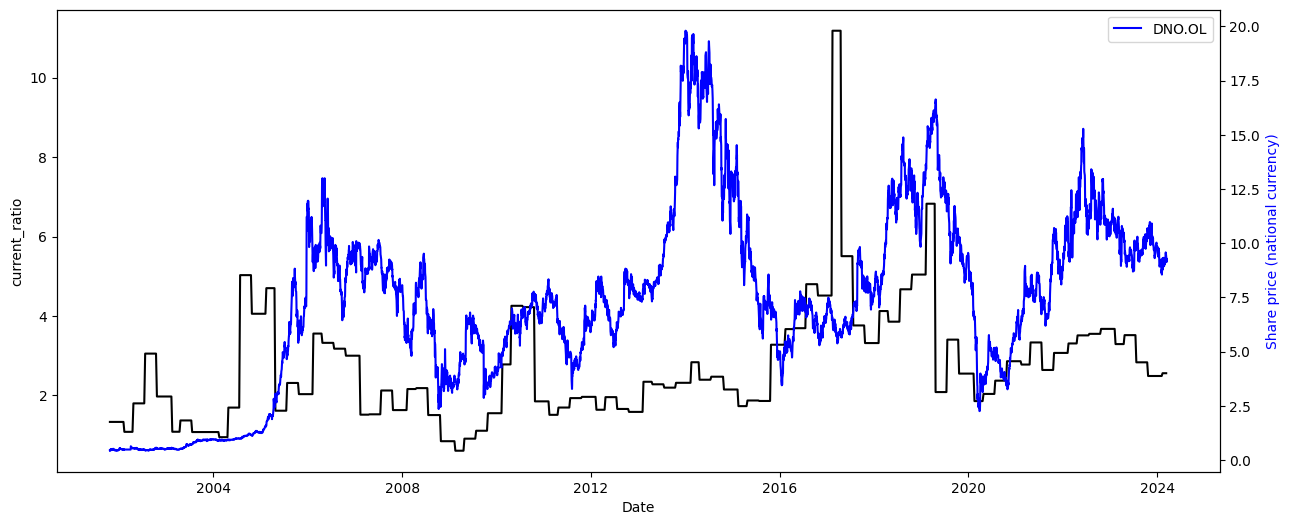

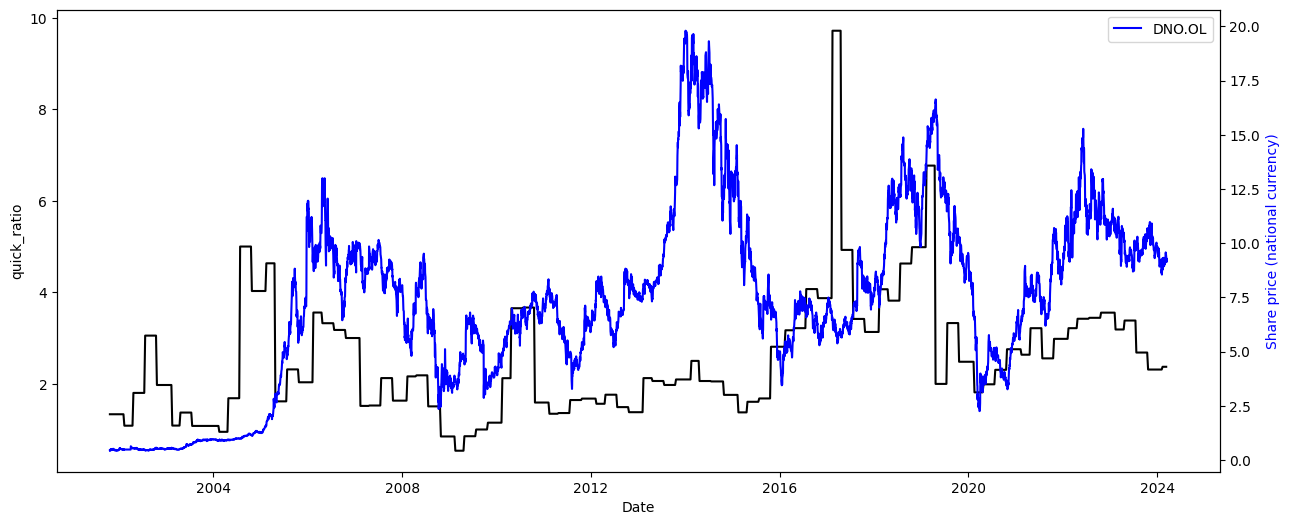

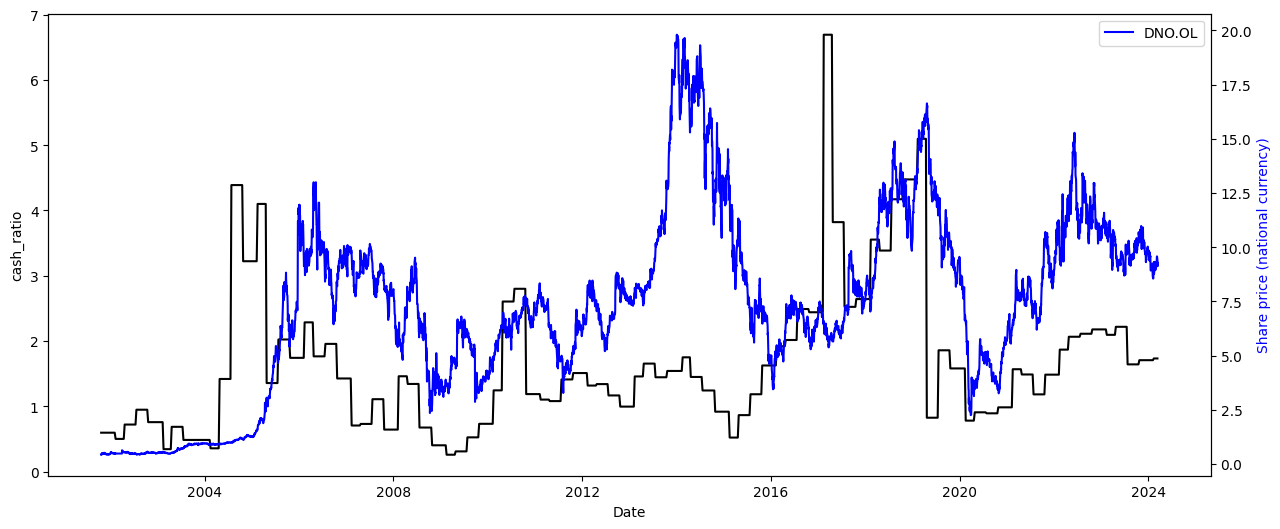

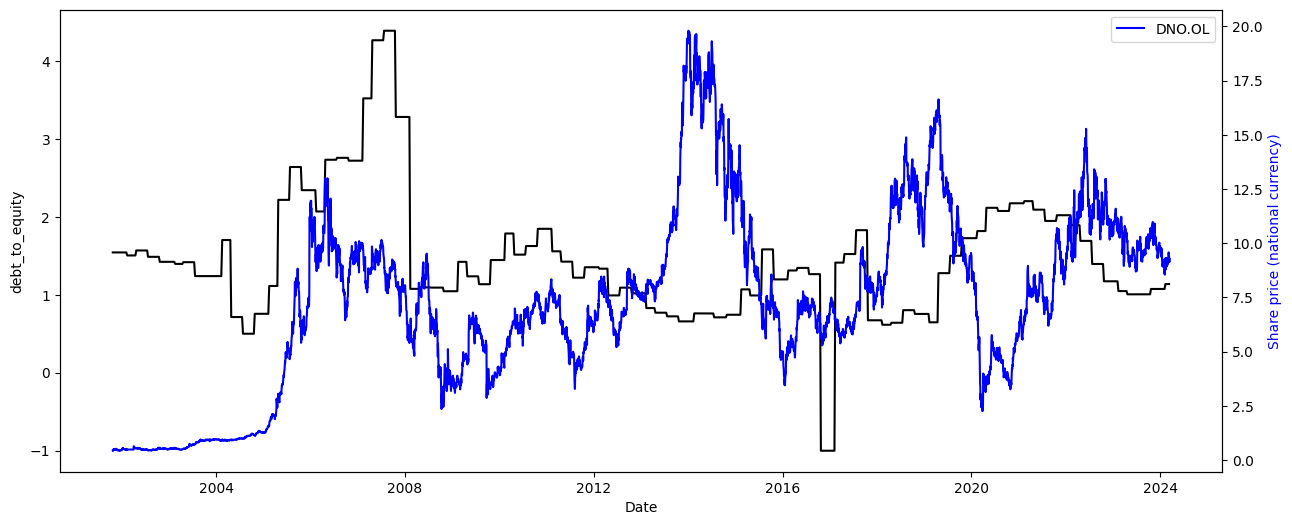

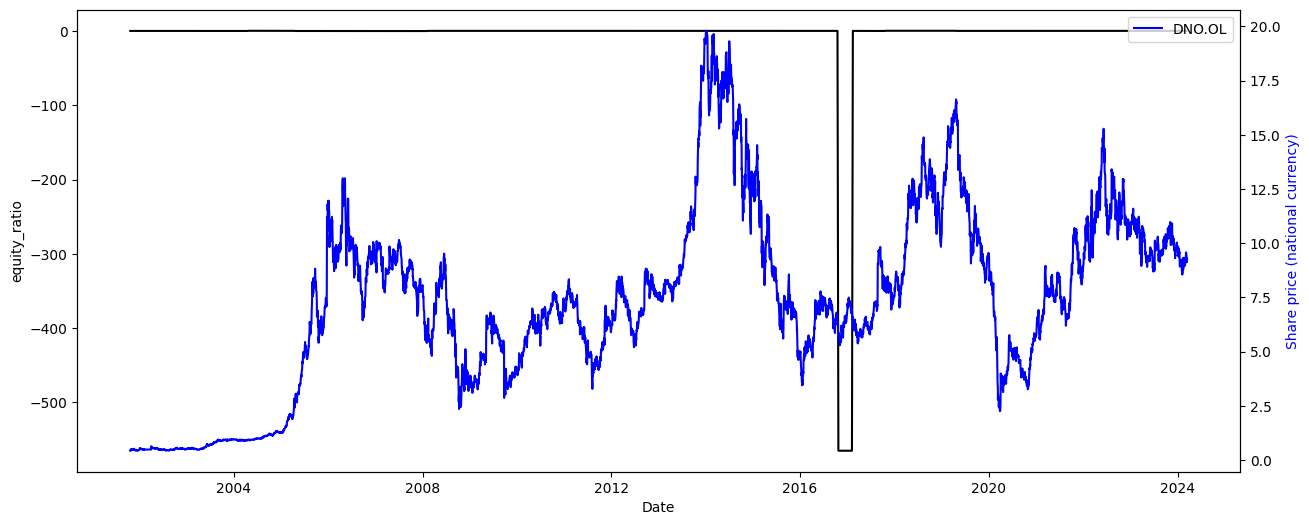

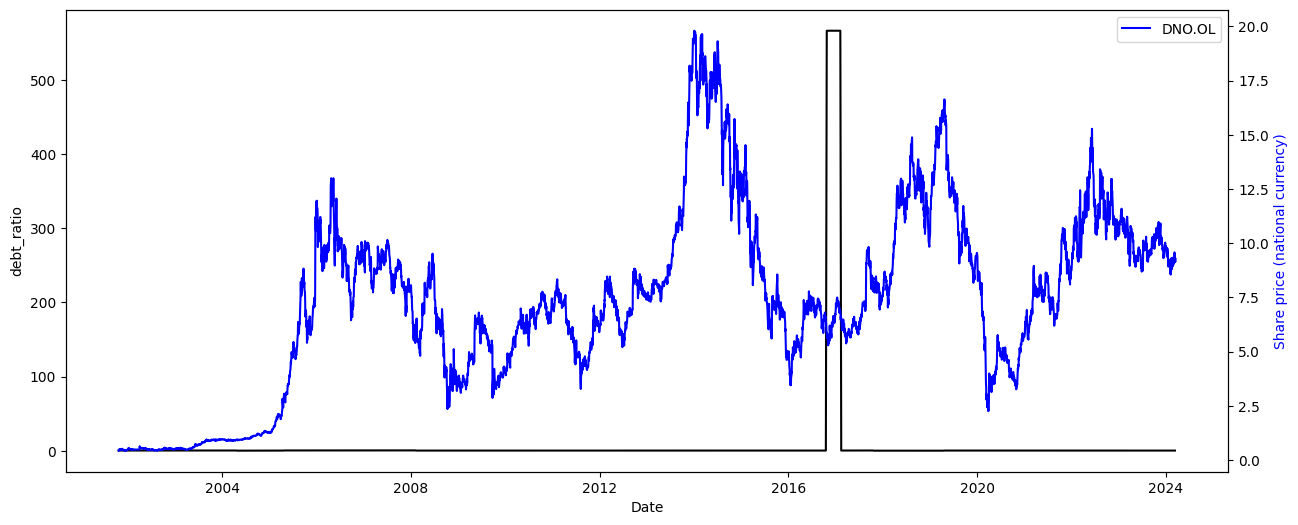

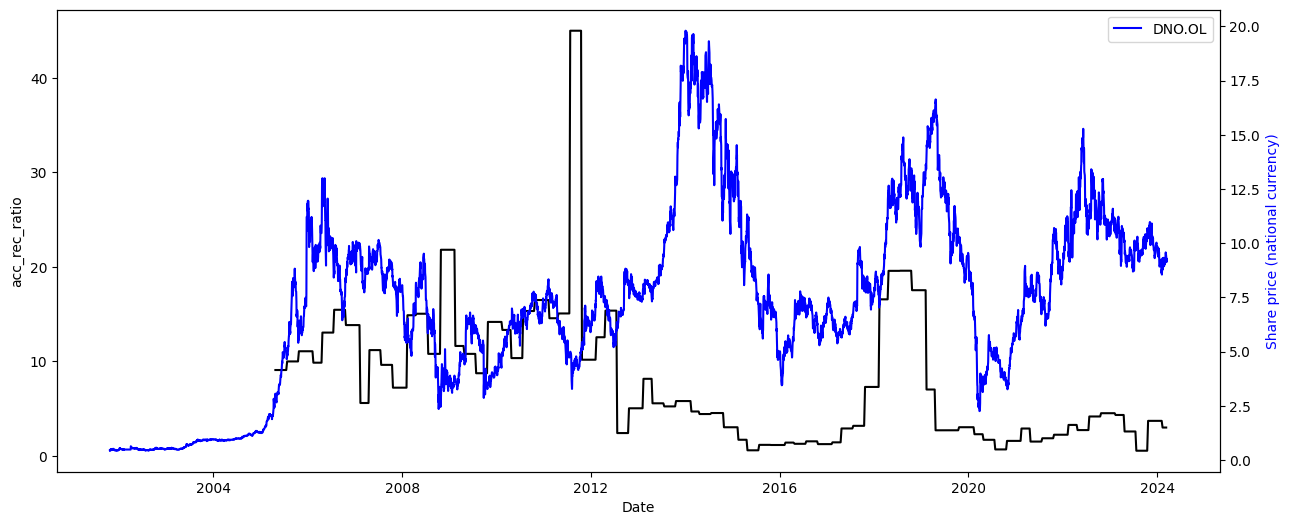

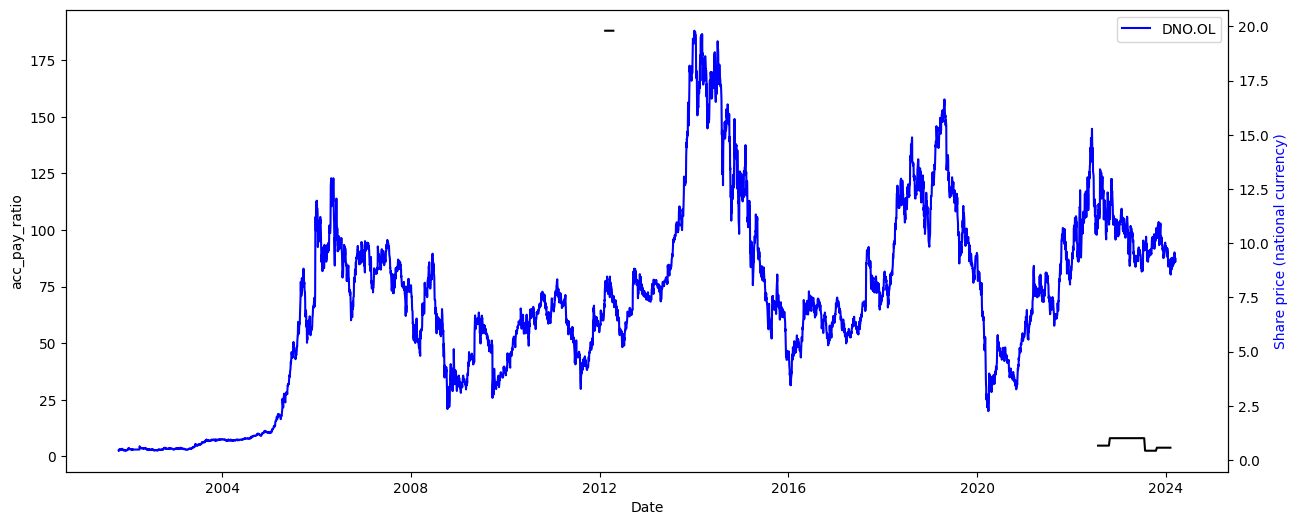

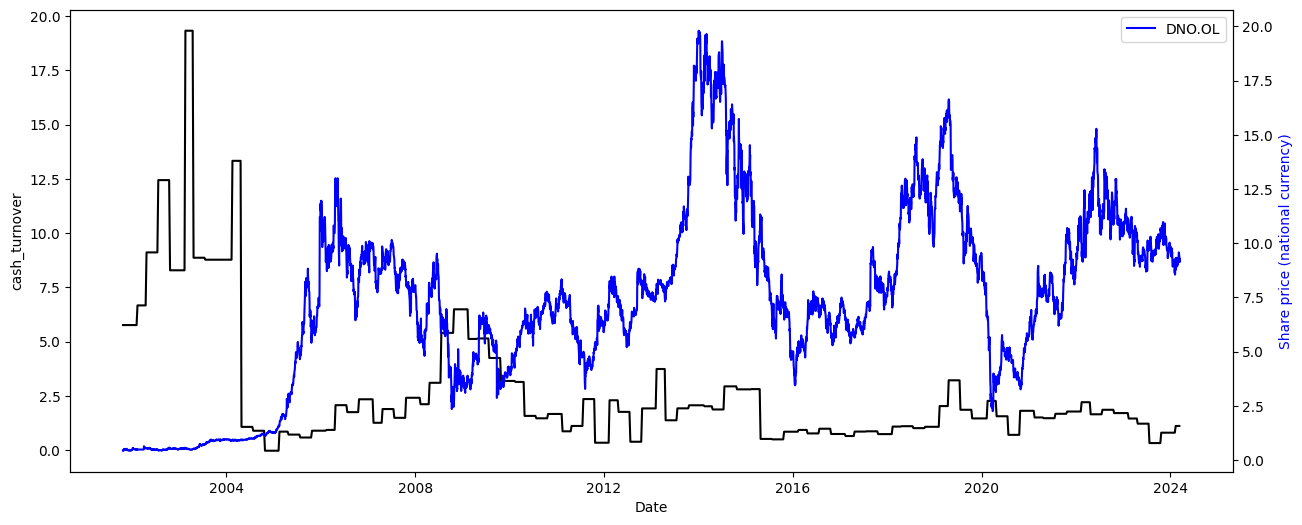

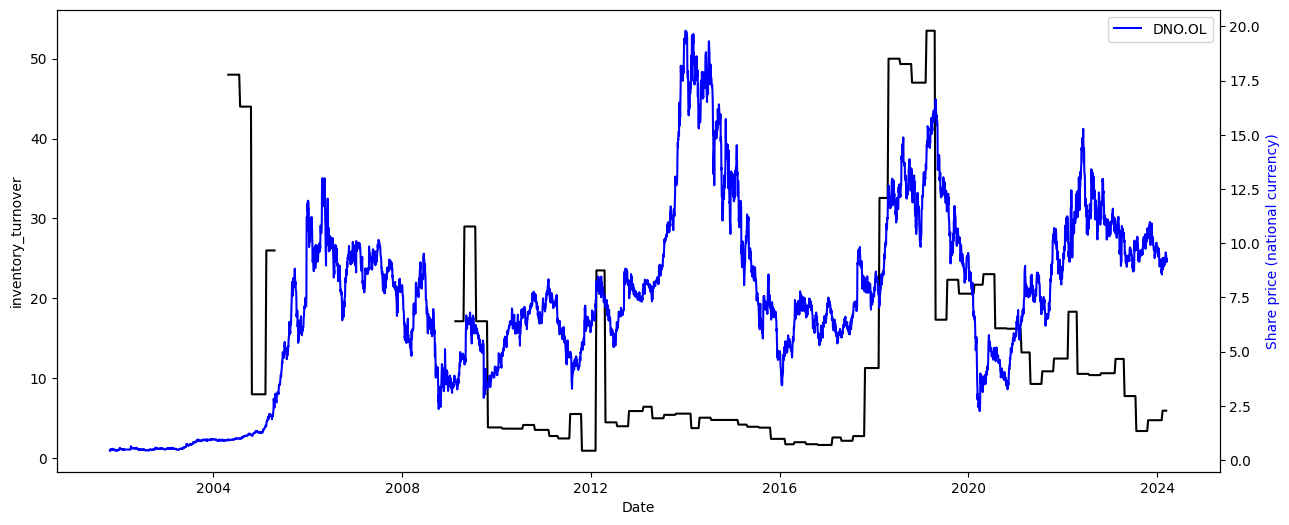

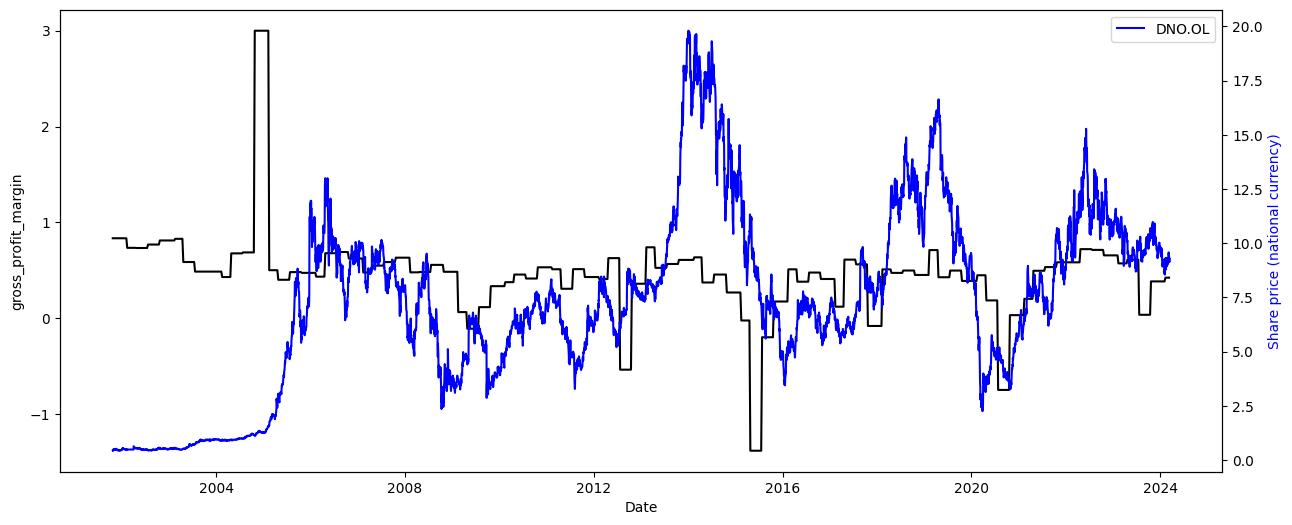

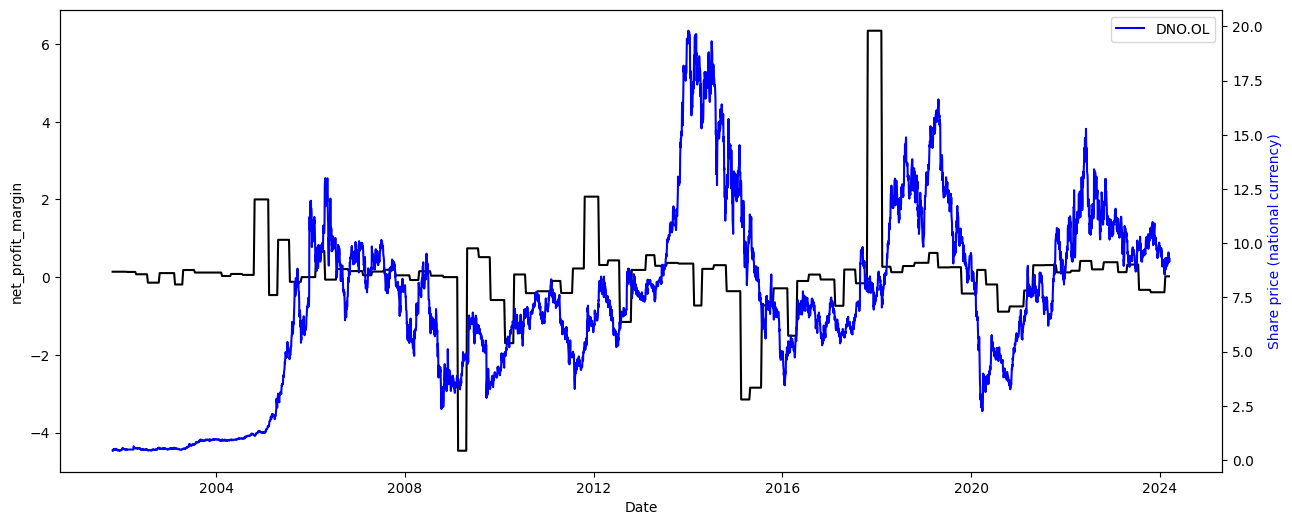

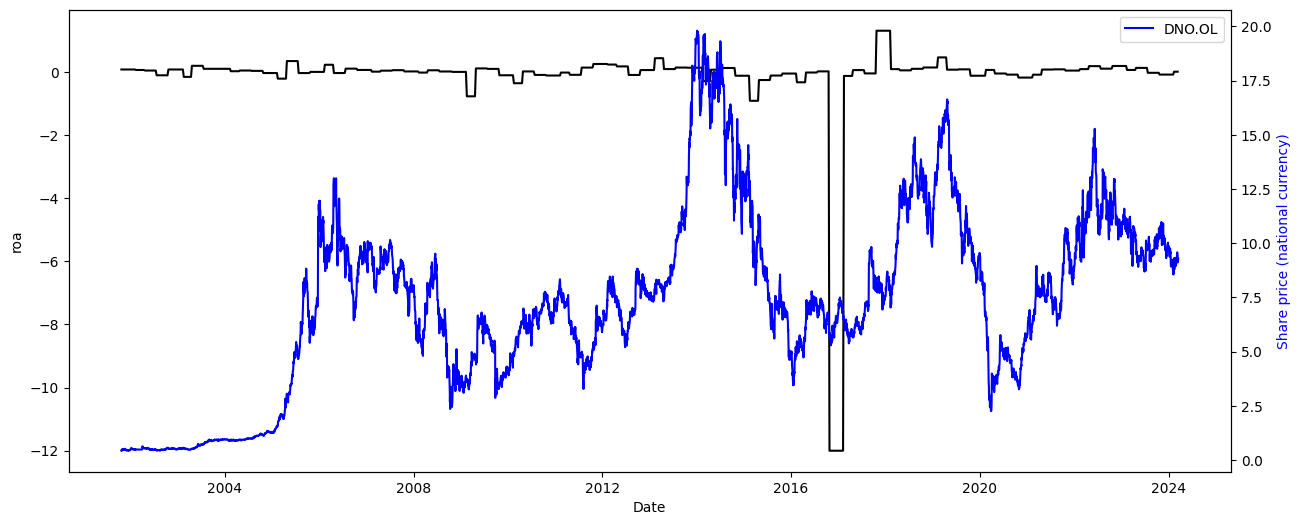

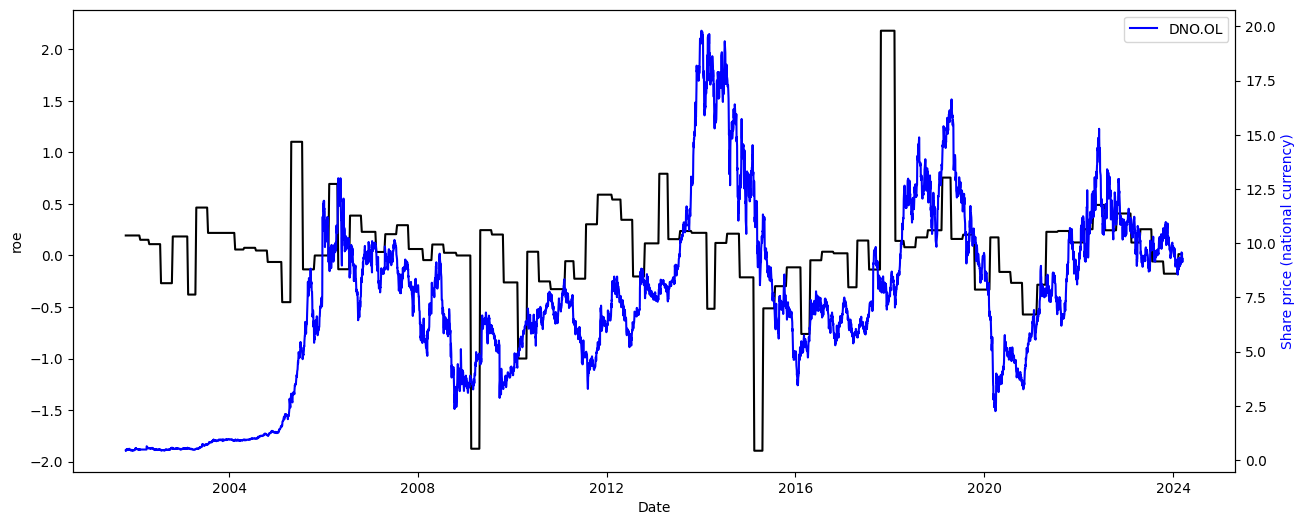

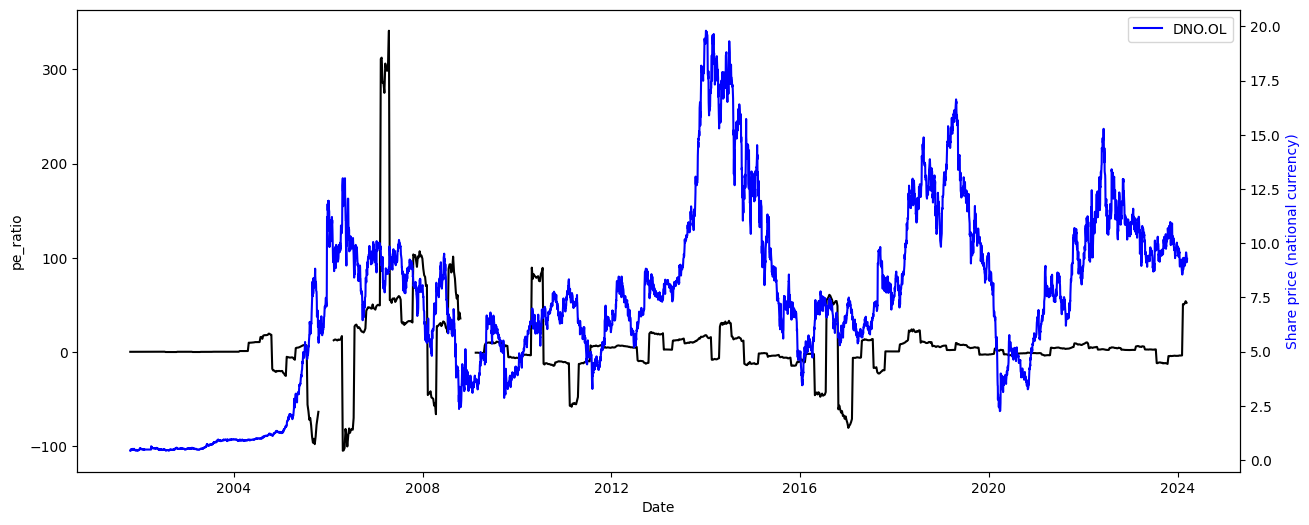

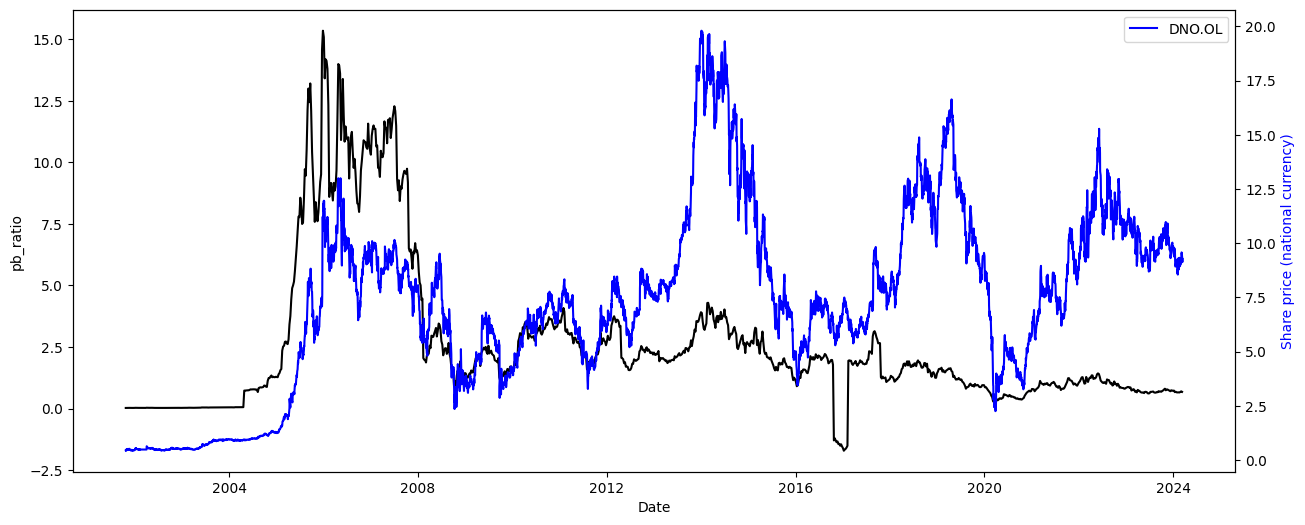

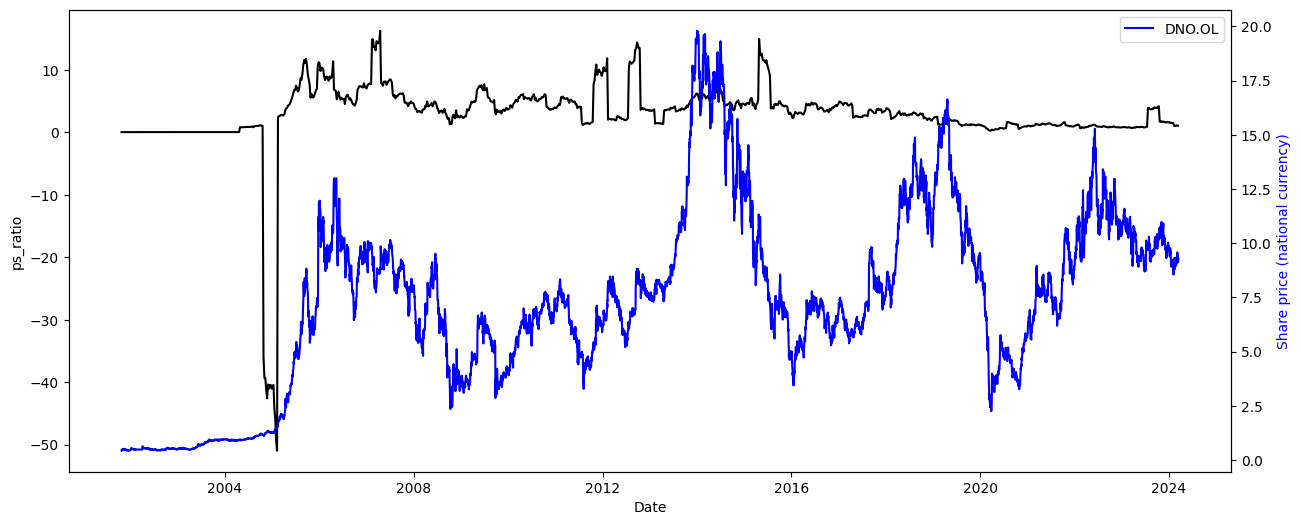

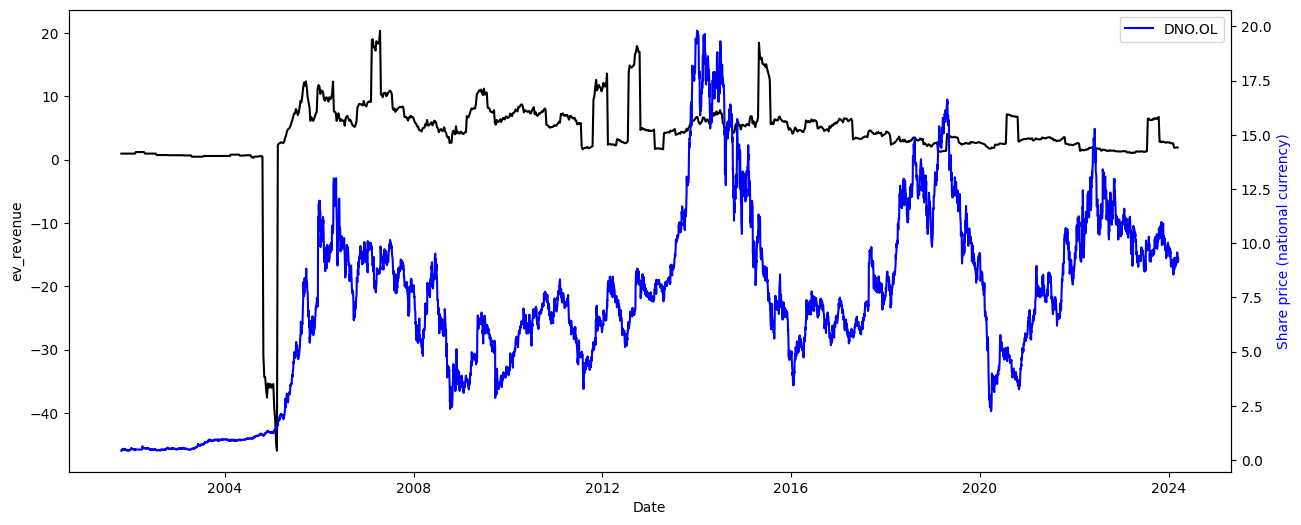

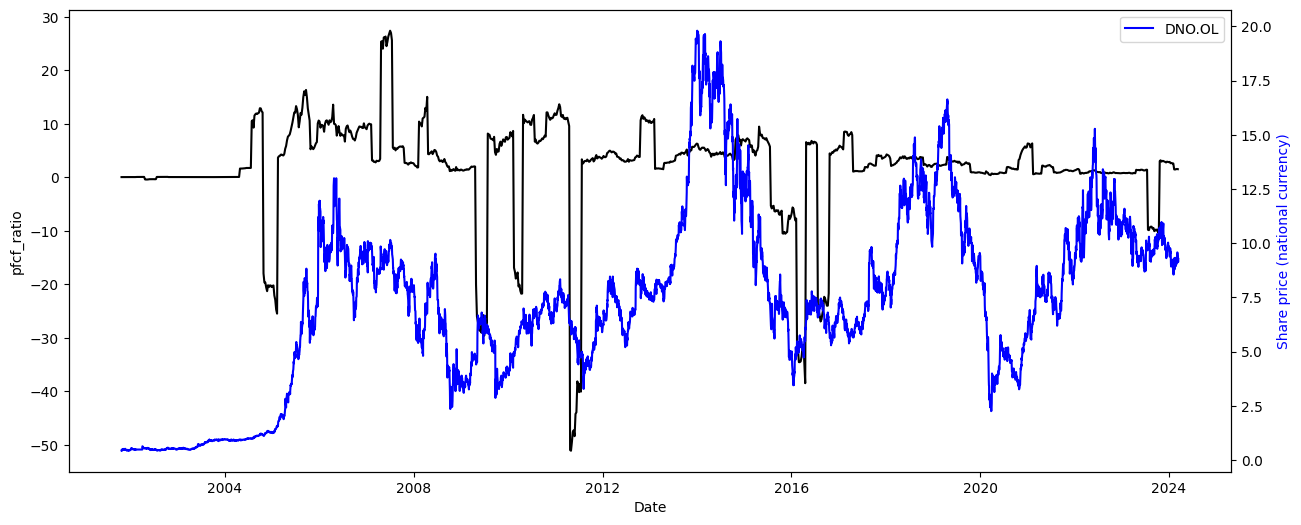

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

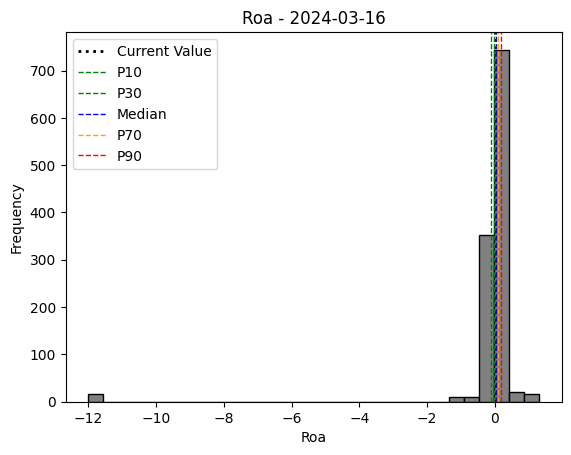

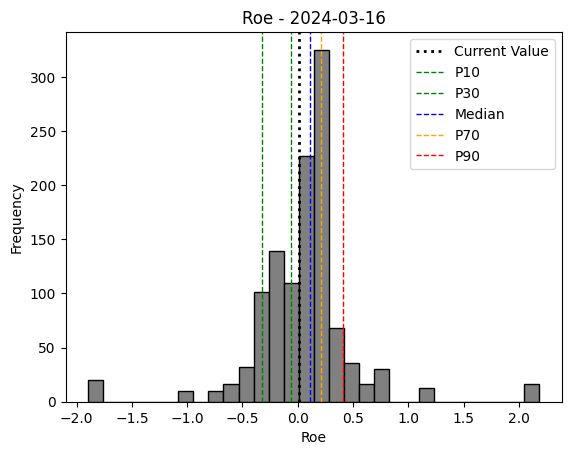

pe_ratio diagram is missing due to error.


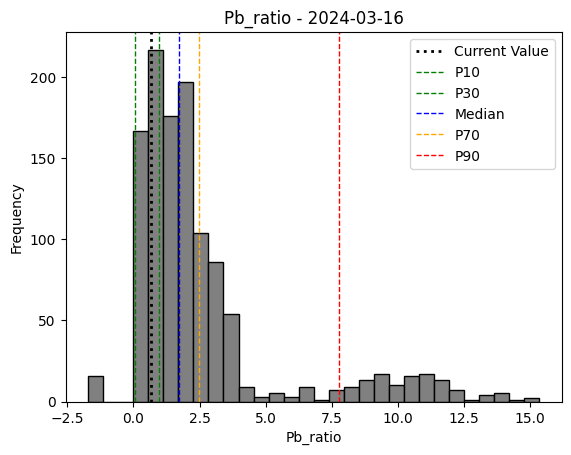

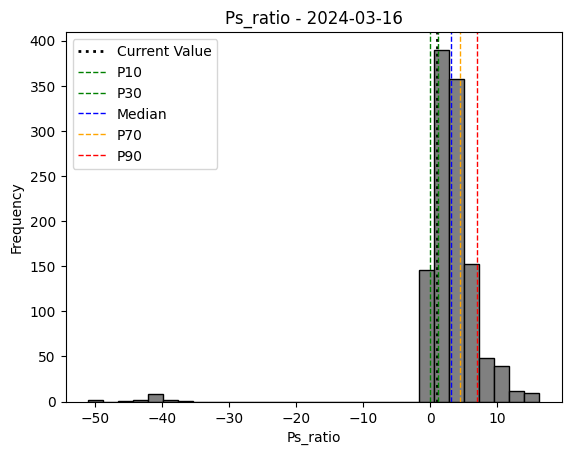

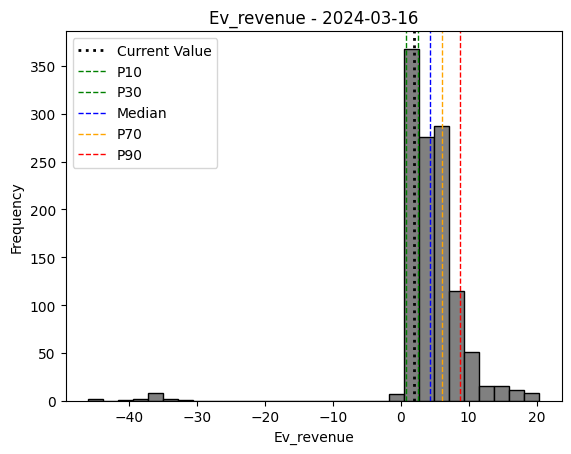

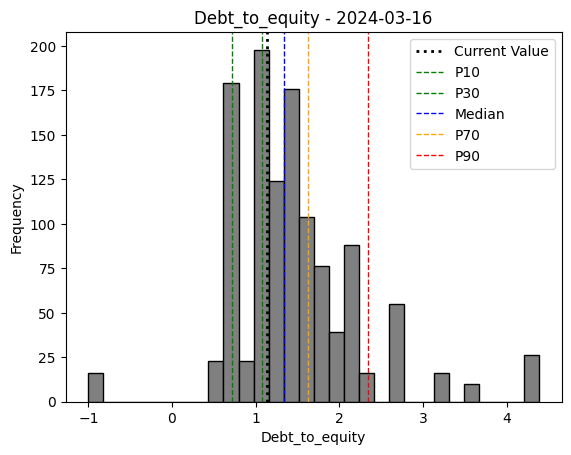

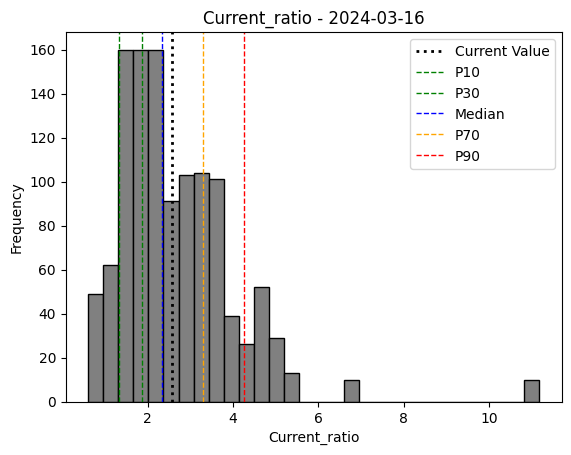

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.166198,0.237744,0.154034,-0.030478,-0.043686,0.344193,-0.135079
roe,0.166198,1.000000,0.111456,0.052326,-0.009809,-0.071065,-0.037164,0.067467
pe_ratio,0.237744,0.111456,1.000000,0.252598,0.183717,0.212773,0.333857,-0.102803
pb_ratio,0.154034,0.052326,0.252598,1.000000,0.368727,0.380897,0.656554,-0.060954
ps_ratio,-0.030478,-0.009809,0.183717,0.368727,1.000000,0.984175,0.209293,-0.131581
ev_revenue,-0.043686,-0.071065,0.212773,0.380897,0.984175,1.000000,0.258579,-0.162011
debt_to_equity,0.344193,-0.037164,0.333857,0.656554,0.209293,0.258579,1.000000,-0.196206
current_ratio,-0.135079,0.067467,-0.102803,-0.060954,-0.131581,-0.162011,-0.196206,1.000000


5 timestemos have been found!


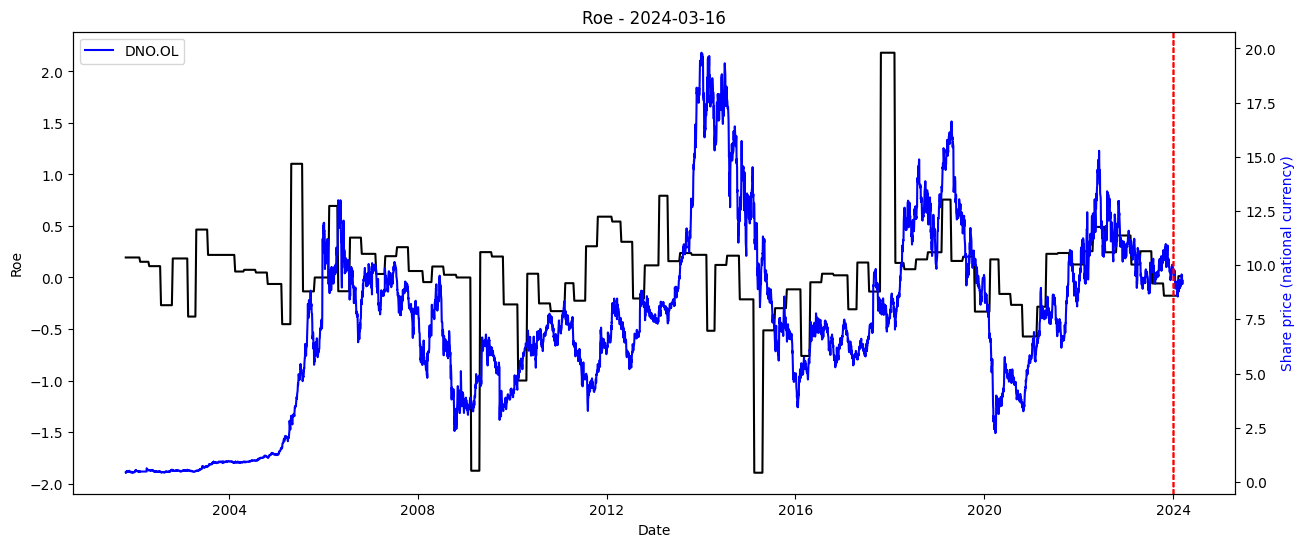

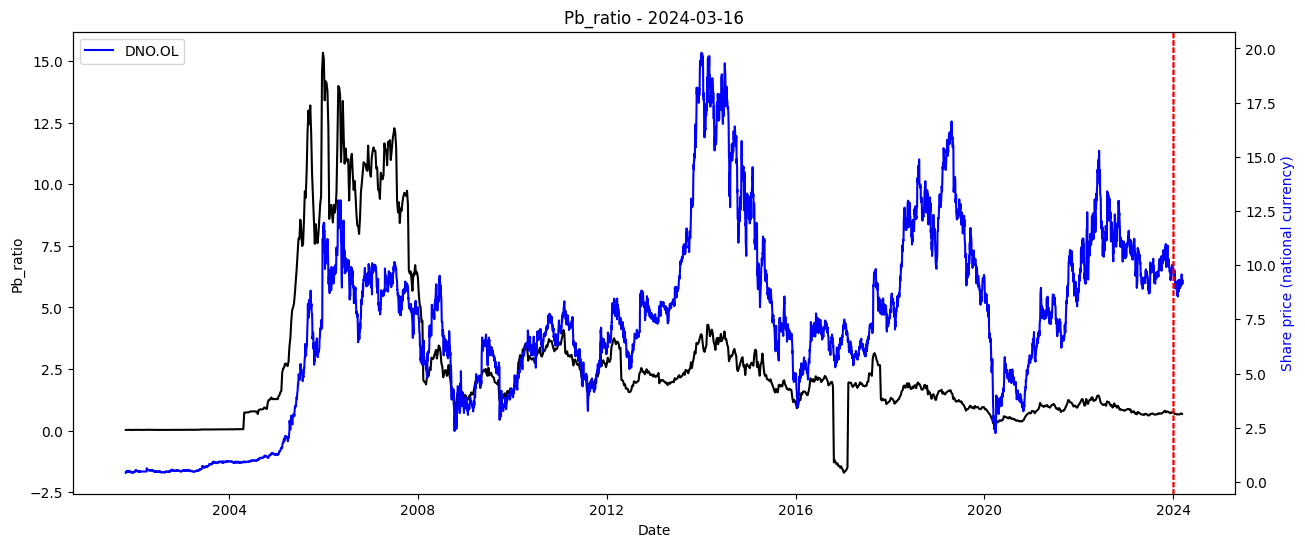

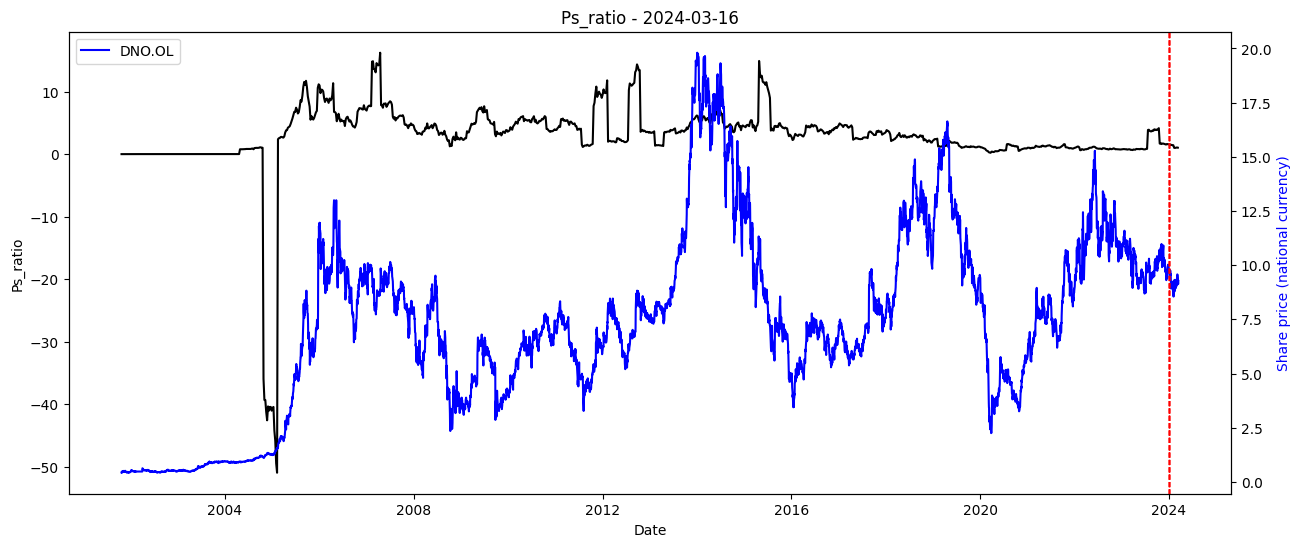

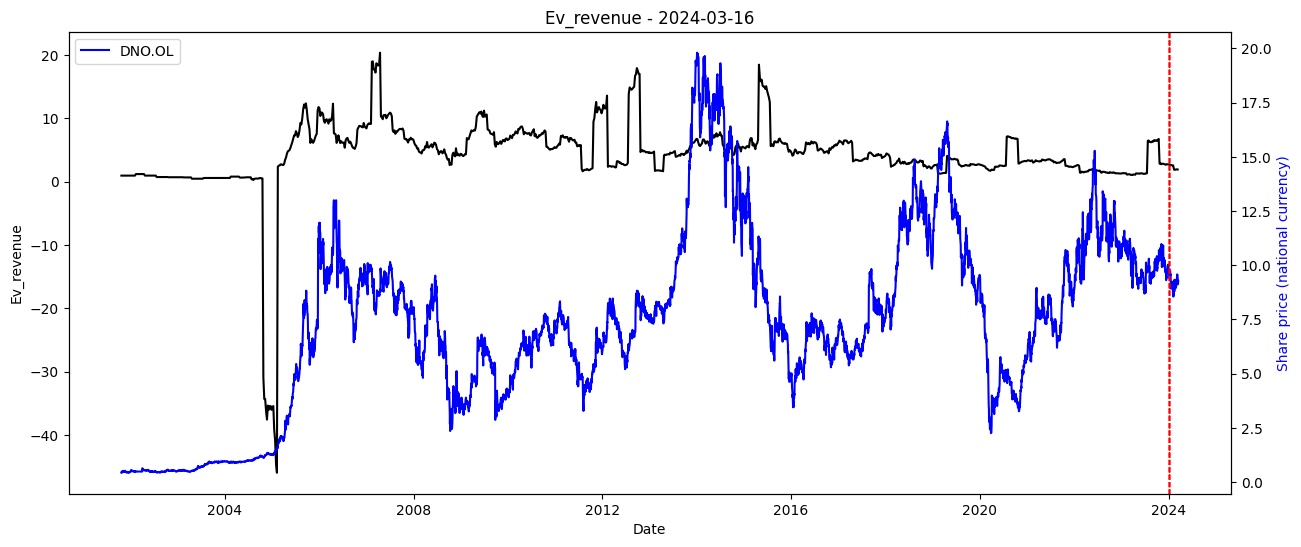

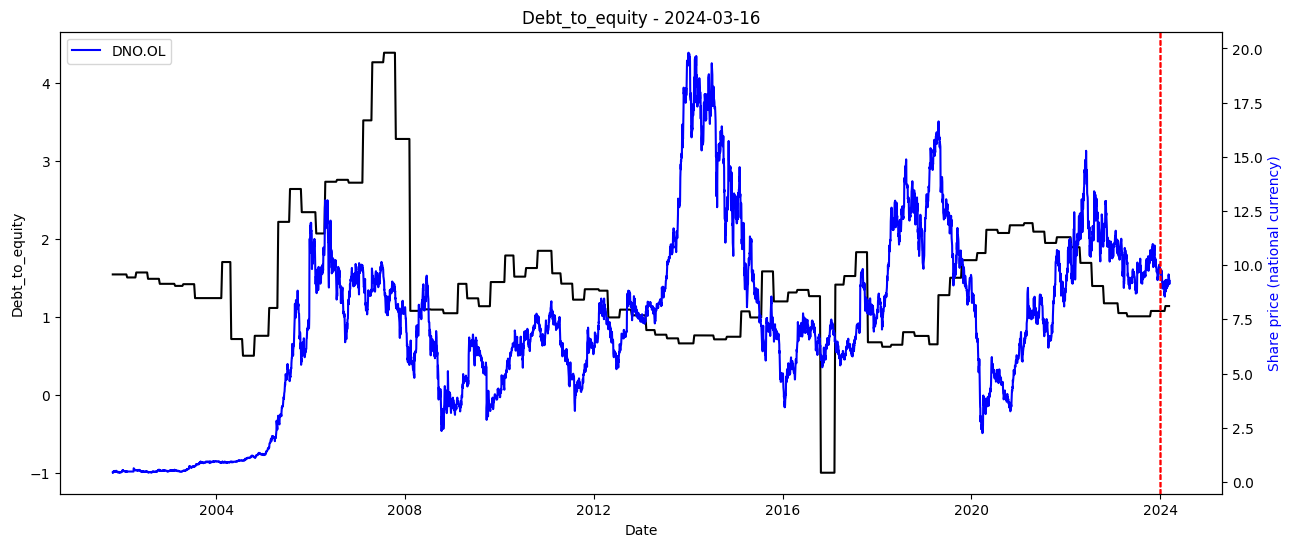

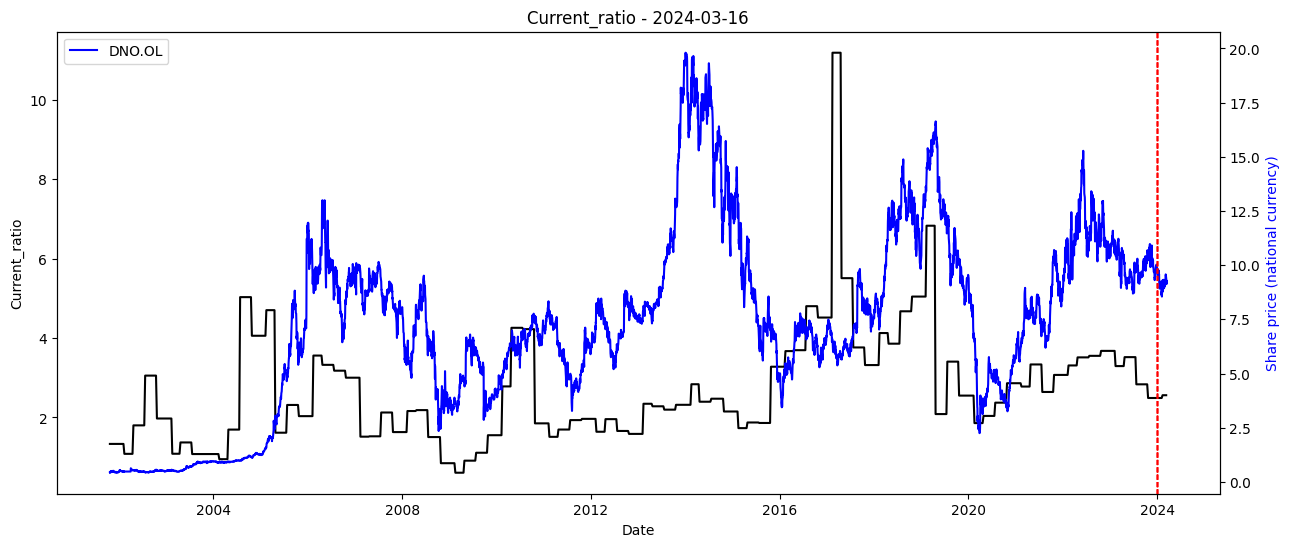

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )